In [3]:
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image             
from keras_preprocessing.image import ImageDataGenerator  
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [6]:
%cd dataset_sibi

e:\Dev Project\.Clone\Bahasa-Isyarat-Detection\dataset_sibi


## Preprocessing

In [7]:
SignLanguageDetection = os.listdir(os.path.join('../dataset_sibi/'))
print("Dataset length: ", len(SignLanguageDetection))
print(SignLanguageDetection)

Dataset length:  26
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [10]:
for signlanguage in SignLanguageDetection:
    print(f'{signlanguage} images: ', len(os.listdir(f'../dataset_sibi/{signlanguage}')))

A images:  220
B images:  220
C images:  220
D images:  220
E images:  220
F images:  220
G images:  220
H images:  220
I images:  220
J images:  21
K images:  220
L images:  220
M images:  220
N images:  220
O images:  220
P images:  220
Q images:  220
R images:  220
S images:  220
T images:  220
U images:  220
V images:  220
W images:  220
X images:  220
Y images:  220
Z images:  21


In [11]:
train_folder = os.path.join('../dataset_sibi')
all_data = []
for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    only_files = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += (only_files)

data = pd.DataFrame(all_data)
data


,label,path
0,A,../dataset_sibi\A\1645707869.4431655.jpg
1,A,../dataset_sibi\A\1645707871.4600735.jpg
2,A,../dataset_sibi\A\1645707873.4433305.jpg
3,A,../dataset_sibi\A\1645707875.362499.jpg
4,A,../dataset_sibi\A\1645707878.1629865.jpg
...,...,...
5317,Z,../dataset_sibi\Z\Z5.png
5318,Z,../dataset_sibi\Z\Z6.png
5319,Z,../dataset_sibi\Z\Z7.png
5320,Z,../dataset_sibi\Z\Z8.png


In [12]:
# train and test split
x_train, x_holdout = train_test_split(data, test_size=0.1, random_state=42, stratify=data[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.2, random_state=42,stratify=x_train[['label']])


### Image data generator

In [13]:
# BASIS_DIR = "../dataset_sibi/"
training_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range=20,
    brightness_range=[0.2,1.0], 
    height_shift_range=0.1,
    shear_range=0.2, 
    zoom_range=0.1,  
    horizontal_flip=True,  
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

holdout_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
y_col = 'label'
x_col = 'path'
no_of_classes = len(data[y_col].unique())

train_generator = training_datagen.flow_from_dataframe( 
    dataframe=x_train,  x_col=x_col, y_col=y_col, 
    target_size=(150,150), 
    class_mode='categorical', 
    shuffle=False,                                                               
    batch_size=128,
    
)


validation_generator = validation_datagen.flow_from_dataframe(      
    dataframe=x_holdout, x_col=x_col, y_col=y_col,      
    target_size=(150,150),      
    class_mode='categorical',
    shuffle=False,
    batch_size=128
)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(150, 150), 
    class_mode='categorical', 
    batch_size=128,
    shuffle=False
)


Found 3831 validated image filenames belonging to 26 classes.
Found 533 validated image filenames belonging to 26 classes.
Found 533 validated image filenames belonging to 26 classes.


In [15]:
# Show the first batch of images

for batch, labels in train_generator:
    print('Train generator')
    print(batch.shape)
    print(labels.shape)
    break
    
print()

for batch, labels in validation_generator:
    print('Validation generator')
    print(batch.shape)
    print(labels.shape)
    break

print()
for batch, labels in holdout_generator:
    print('Holdout generator')
    print(batch.shape)
    print(labels.shape)
    break

Train generator
(128, 150, 150, 3)
(128, 26)

Validation generator
(128, 150, 150, 3)
(128, 26)

Holdout generator
(128, 150, 150, 3)
(128, 26)


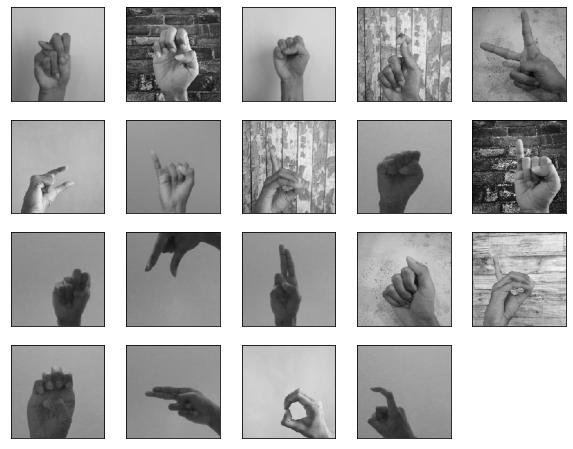

In [16]:
# Show images

plt.figure(figsize=(10,10))

for i in range(19):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch[i], cmap=plt.cm.binary)

In [17]:
# Adam
Adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

# RMSprop
RMSprop = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001, rho=0.7, epsilon=1e-08, decay=0.0)

## Modeling: CNN

### Optimizer Adam

In [18]:
model1 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(26, activation='softmax')
         ])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [19]:
%%time
model1.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
history1 = model1.fit(train_generator, epochs=32, validation_data=validation_generator, verbose=1)

Epoch 1/32
30/30 [==============================] - 56s 2s/step - loss: 3.2366 - accuracy: 0.0418 - val_loss: 3.2114 - val_accuracy: 0.0432
Epoch 2/32
30/30 [==============================] - 42s 1s/step - loss: 3.2071 - accuracy: 0.0433 - val_loss: 3.1872 - val_accuracy: 0.0600
Epoch 3/32
30/30 [==============================] - 43s 1s/step - loss: 3.1853 - accuracy: 0.0720 - val_loss: 3.1382 - val_accuracy: 0.0807
Epoch 4/32
30/30 [==============================] - 41s 1s/step - loss: 3.1367 - accuracy: 0.0841 - val_loss: 3.0830 - val_accuracy: 0.1051
Epoch 5/32
30/30 [==============================] - 41s 1s/step - loss: 3.0678 - accuracy: 0.1036 - val_loss: 3.0430 - val_accuracy: 0.0919
Epoch 6/32
30/30 [==============================] - 41s 1s/step - loss: 3.0075 - accuracy: 0.1167 - val_loss: 2.9703 - val_accuracy: 0.1107
Epoch 7/32
30/30 [==============================] - 41s 1s/step - loss: 2.9530 - accuracy: 0.1373 - val_loss: 2.9800 - val_accuracy: 0.0994
Epoch 8/32
30/30 [==

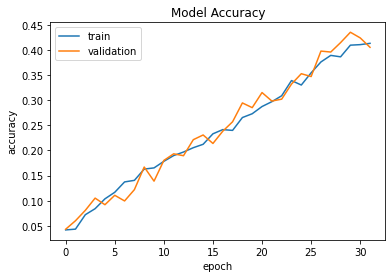

In [20]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

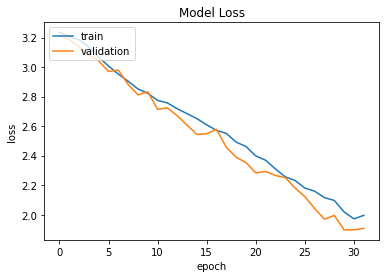

In [21]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Optimizer RMSprop

In [22]:
model3 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(26, activation='softmax')
         ])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [23]:
%%time
model3.compile(loss='categorical_crossentropy', optimizer=RMSprop , metrics=['accuracy'])
history3 = model3.fit(train_generator, epochs=32, validation_data=validation_generator, verbose=1)

Epoch 1/32
30/30 [==============================] - 44s 1s/step - loss: 3.2789 - accuracy: 0.0452 - val_loss: 3.2088 - val_accuracy: 0.0525
Epoch 2/32
30/30 [==============================] - 42s 1s/step - loss: 3.1241 - accuracy: 0.0945 - val_loss: 3.1420 - val_accuracy: 0.0694
Epoch 3/32
30/30 [==============================] - 41s 1s/step - loss: 2.9114 - accuracy: 0.1551 - val_loss: 2.9136 - val_accuracy: 0.1595
Epoch 4/32
30/30 [==============================] - 41s 1s/step - loss: 2.7559 - accuracy: 0.1851 - val_loss: 2.8914 - val_accuracy: 0.1782
Epoch 5/32
30/30 [==============================] - 41s 1s/step - loss: 2.6140 - accuracy: 0.2172 - val_loss: 2.7287 - val_accuracy: 0.2120
Epoch 6/32
30/30 [==============================] - 41s 1s/step - loss: 2.4452 - accuracy: 0.2704 - val_loss: 2.4384 - val_accuracy: 0.2702
Epoch 7/32
30/30 [==============================] - 41s 1s/step - loss: 2.3448 - accuracy: 0.3104 - val_loss: 2.8707 - val_accuracy: 0.1782
Epoch 8/32
30/30 [==

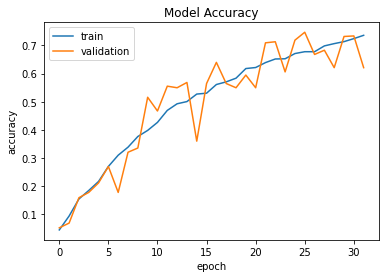

In [24]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

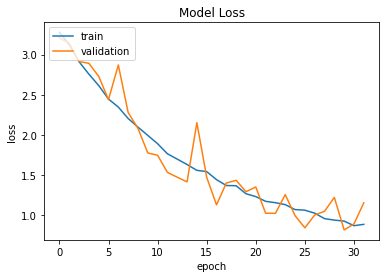

In [25]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Modeling: Transfer Learning MobileNetV2

In [26]:
img_size = 128
img_shape = (img_size, img_size, 3)

model_mobilenetV2 = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
model_mobilenetV2.trainable = False

In [27]:
model_mobilenetV2.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

### Optimizer RMSProp

In [28]:
mobilenetV2_model = tf.keras.models.Sequential([
                        model_mobilenetV2,
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(26, activation='softmax')
                    ])

mobilenetV2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2621568   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                      

In [29]:
%%time
mobilenetV2_model.compile(loss='categorical_crossentropy', optimizer=RMSprop , metrics=['accuracy'])
history4 = mobilenetV2_model.fit(train_generator, epochs=32, validation_data=validation_generator, verbose=1)


Epoch 1/32
30/30 [==============================] - 36s 1s/step - loss: 3.2491 - accuracy: 0.1068 - val_loss: 2.6632 - val_accuracy: 0.1970
Epoch 2/32
30/30 [==============================] - 35s 1s/step - loss: 2.3547 - accuracy: 0.2986 - val_loss: 1.9428 - val_accuracy: 0.4484
Epoch 3/32
30/30 [==============================] - 33s 1s/step - loss: 1.6334 - accuracy: 0.5087 - val_loss: 1.0598 - val_accuracy: 0.6679
Epoch 4/32
30/30 [==============================] - 33s 1s/step - loss: 1.2017 - accuracy: 0.6299 - val_loss: 1.2164 - val_accuracy: 0.6154
Epoch 5/32
30/30 [==============================] - 35s 1s/step - loss: 1.0183 - accuracy: 0.6842 - val_loss: 0.7091 - val_accuracy: 0.7917
Epoch 6/32
30/30 [==============================] - 35s 1s/step - loss: 0.8157 - accuracy: 0.7531 - val_loss: 0.5331 - val_accuracy: 0.8405
Epoch 7/32
30/30 [==============================] - 33s 1s/step - loss: 0.7164 - accuracy: 0.7797 - val_loss: 0.5294 - val_accuracy: 0.8386
Epoch 8/32
30/30 [==

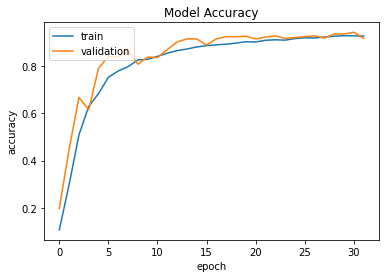

In [30]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

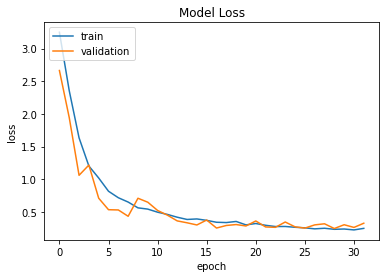

In [31]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Optimizer Adam

In [32]:
mobilenetV2_model2 = tf.keras.models.Sequential([
                        model_mobilenetV2,
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(26, activation='softmax')
                    ])

mobilenetV2_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 20480)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               2621568   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                      

In [33]:
%%time
mobilenetV2_model2.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
history5 = mobilenetV2_model2.fit(train_generator, epochs=32, validation_data=validation_generator, verbose=1)

Epoch 1/32
30/30 [==============================] - 36s 1s/step - loss: 2.5204 - accuracy: 0.2535 - val_loss: 1.5933 - val_accuracy: 0.5235
Epoch 2/32
30/30 [==============================] - 32s 1s/step - loss: 1.4119 - accuracy: 0.5821 - val_loss: 0.9186 - val_accuracy: 0.7523
Epoch 3/32
30/30 [==============================] - 35s 1s/step - loss: 0.9564 - accuracy: 0.7092 - val_loss: 0.6901 - val_accuracy: 0.7917
Epoch 4/32
30/30 [==============================] - 35s 1s/step - loss: 0.7421 - accuracy: 0.7781 - val_loss: 0.5571 - val_accuracy: 0.8424
Epoch 5/32
30/30 [==============================] - 32s 1s/step - loss: 0.6169 - accuracy: 0.8181 - val_loss: 0.5112 - val_accuracy: 0.8443
Epoch 6/32
30/30 [==============================] - 35s 1s/step - loss: 0.5305 - accuracy: 0.8486 - val_loss: 0.4483 - val_accuracy: 0.8687
Epoch 7/32
30/30 [==============================] - 33s 1s/step - loss: 0.4939 - accuracy: 0.8588 - val_loss: 0.4105 - val_accuracy: 0.8762
Epoch 8/32
30/30 [==

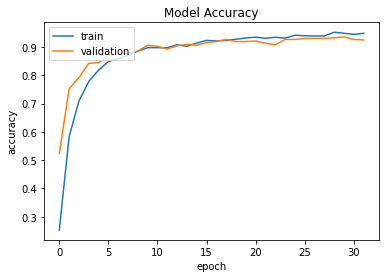

In [34]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

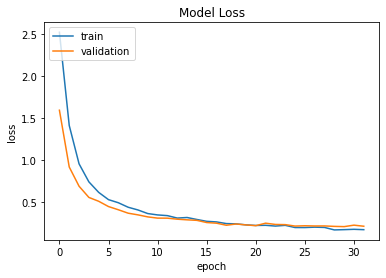

In [35]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## saving model

In [36]:
model1.save('../model/model1.h5') #cnn adam
model3.save('../model/model3.h5') #cnn rmsprop
mobilenetV2_model.save('../model/mobilenetV2_model.h5') #mobilenetV2 rmsprop
mobilenetV2_model2.save('../model/mobilenetV2_model2.h5') #mobilenetV2 adam


## load model

In [37]:
model1 = tf.keras.models.load_model('../model/model1.h5') #cnn adam
model2 = tf.keras.models.load_model('../model/model3.h5') #cnn rmsprop
model3 = tf.keras.models.load_model('../model/mobilenetV2_model.h5') #mobilenetV2 rmsprop
model4 = tf.keras.models.load_model('../model/mobilenetV2_model2.h5') #mobilenetV2 adam


## Evaluation

In [38]:
model1.evaluate(validation_generator)

5/5 [==============================] - 1s 218ms/step - loss: 1.9068 - accuracy: 0.4053


[1.9068149328231812, 0.4052532911300659]

In [39]:
model2.evaluate(validation_generator)

5/5 [==============================] - 1s 217ms/step - loss: 1.1500 - accuracy: 0.6210


[1.1500004529953003, 0.6210131049156189]

In [40]:
model3.evaluate(validation_generator)

5/5 [==============================] - 4s 516ms/step - loss: 0.3261 - accuracy: 0.9174


[0.3261137902736664, 0.9174484014511108]

In [41]:
model4.evaluate(validation_generator)

5/5 [==============================] - 4s 521ms/step - loss: 0.2145 - accuracy: 0.9250


[0.21445605158805847, 0.9249531030654907]

### model 1

In [42]:
eva_model1 = model1.predict(validation_generator)
C1 = confusion_matrix(validation_generator.classes, np.argmax(eva_model1, axis=1))
print(C1)

5/5 [==============================] - 1s 218ms/step
[[ 5  0  0  0  1  0  0  0 10  0  0  0  4  0  0  0  1  0  0  0  0  0  0  0
   1  0]
 [ 0 11  1  0  2  2  0  0  1  0  3  0  0  0  0  0  0  0  0  0  1  1  0  0
   0  0]
 [ 4  0  5  0  1  0  1  0  0  0  0  0  0  0  1  0  0  0  2  1  1  0  0  6
   0  0]
 [ 0  0  0  5  0  0  0  0  3  0  3  8  0  0  0  0  0  0  1  1  0  0  0  0
   1  0]
 [ 1  2  0  0 12  4  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1
   0  0]
 [ 3  1  0  0  2  9  0  0  3  0  2  0  0  0  0  0  0  0  0  1  1  0  0  0
   0  0]
 [ 1  0  2  2  1  0  9  0  1  0  1  2  0  0  1  0  0  0  1  0  0  0  0  1
   0  0]
 [ 0  0  1  0  0  0  3 12  0  0  1  3  0  0  0  1  0  0  1  0  0  0  0  0
   0  0]
 [ 1  0  0  0  0  0  0  0 12  0  1  2  1  0  0  0  0  0  0  0  0  0  0  1
   4  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  1  0  0  1  0 17  0  0  0  0  0  0  0  1  1  0  0  0  0
   1  0]
 [ 0  0  0  1  0  1  0  0  2  0  2

In [43]:
y_pred1 = model1.predict(validation_generator, verbose=1)
y_pred1 = np.argmax(y_pred1, axis=1)
print(accuracy_score(validation_generator.classes, y_pred1))

5/5 [==============================] - 1s 215ms/step
0.4052532833020638


### model 2

In [44]:
eva_model2= model2.predict(validation_generator)
C2 = confusion_matrix(validation_generator.classes, np.argmax(eva_model2, axis=1))
print(C2)

5/5 [==============================] - 1s 217ms/step
[[19  0  0  0  0  1  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0 11  0  0  0  5  0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  1  0
   0  0]
 [ 0  0 19  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
   0  0]
 [ 0  0  1 14  0  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  4  0  0  0
   0  0]
 [ 4  0  0  0 10  5  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0
   0  0]
 [ 0  1  0  0  0 17  0  0  0  0  1  0  0  0  0  0  0  0  0  0  3  0  0  0
   0  0]
 [ 0  0  5  0  0  0 14  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0]
 [ 1  0  0  0  0  0  6 12  0  0  0  2  0  0  0  0  0  0  0  0  0  1  0  0
   0  0]
 [ 3  0  0  0  0  1  0  0 10  0  1  0  0  1  0  0  0  0  0  2  1  0  0  0
   3  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0  0  0  0  0  0 15  1  0  0  0  0  0  1  0  0  1  2  1  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2

In [45]:
y_pred2 = model2.predict(validation_generator, verbose=1)
y_pred2 = np.argmax(y_pred2, axis=1)
print(accuracy_score(validation_generator.classes, y_pred2))

5/5 [==============================] - 1s 215ms/step
0.6210131332082551


### model3

In [46]:
eva_model3 = model3.predict(validation_generator)
C3 = confusion_matrix(validation_generator.classes, np.argmax(eva_model3, axis=1))
print(C3)

5/5 [==============================] - 3s 519ms/step
[[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0 21  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  2 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0 20  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0]
 [ 0  1  0  0  1 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0  0  0 17  0  0  0  1  0  0  0  0  1  0  1  1  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0  0  0  0  0 18  0  0  0  0  0  0  1  0  0  1  1  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2

In [47]:
y_pred3 = model3.predict(validation_generator, verbose=1)
y_pred3 = np.argmax(y_pred3, axis=1)
print(accuracy_score(validation_generator.classes, y_pred3))

5/5 [==============================] - 3s 518ms/step
0.9174484052532833


### model4

In [48]:
eva_model4 = model4.predict(validation_generator)
C4 = confusion_matrix(validation_generator.classes, np.argmax(eva_model4, axis=1))
print(C4)

5/5 [==============================] - 4s 520ms/step
[[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0 20  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0]
 [ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0]
 [ 0  0  0 21  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0 19  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0
   0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
   0  0]
 [ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  1  0  0  0 15  0  0  0  1  0  0  0  0  2  0  1  1  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  1  1  0
   0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0

In [49]:
y_pred4 = model4.predict(validation_generator, verbose=1)
y_pred4 = np.argmax(y_pred4, axis=1)
print(accuracy_score(validation_generator.classes, y_pred4))

5/5 [==============================] - 3s 515ms/step
0.924953095684803
